In [1]:
import sys
sys.path.append("../")

from smc.sampler import SMCsampler
from smc.prior import StarPrior
from smc.images import ImageModel
from smc.kernel import MetropolisHastings

import torch
# torch.cuda.is_available()
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
torch.set_default_device(device)

import matplotlib.pyplot as plt

### Generate images

We specify a prior and an image model and generate one image.

In [2]:
TruePrior = StarPrior(max_objects = 100,
                      image_dim = 64,
                      min_flux = 10000)

TrueImageModel = ImageModel(image_dim = 64,
                            psf_stdev = 1,
                            background = 20000)

true_counts, true_locs, true_fluxes, images = TrueImageModel.generate(Prior = TruePrior,
                                                                      num_images = 1)

image 1 
count
 87 
total flux
 8818305.0 
loc
 [[20.139856    2.7144613 ]
 [62.362095   58.191235  ]
 [32.079025   43.86874   ]
 [ 6.3475604  30.189175  ]
 [35.273506   33.831825  ]
 [10.20067    39.017654  ]
 [ 6.1653395  10.724381  ]
 [32.963448   42.589996  ]
 [60.686787   41.619095  ]
 [36.40653    37.044407  ]
 [23.93756    32.55011   ]
 [28.137117   28.501263  ]
 [36.728256   14.264544  ]
 [30.149252   35.98597   ]
 [60.47115    26.354403  ]
 [17.355553   19.073671  ]
 [31.002151    2.1798542 ]
 [54.302383   48.118244  ]
 [ 6.0162363  21.314007  ]
 [18.509829   41.146103  ]
 [23.302822   13.531297  ]
 [54.125153    6.0048356 ]
 [13.448663   15.458325  ]
 [ 4.7891827  19.701649  ]
 [10.906032   62.02362   ]
 [19.628963   18.039898  ]
 [63.406567    4.9231887 ]
 [45.639317   51.86817   ]
 [32.42411     0.28704956]
 [47.95519    55.135395  ]
 [ 0.12914893 49.248974  ]
 [35.091248   35.234715  ]
 [39.48557    33.149403  ]
 [36.192295   35.37597   ]
 [55.99719    53.808598  ]
 [46.61

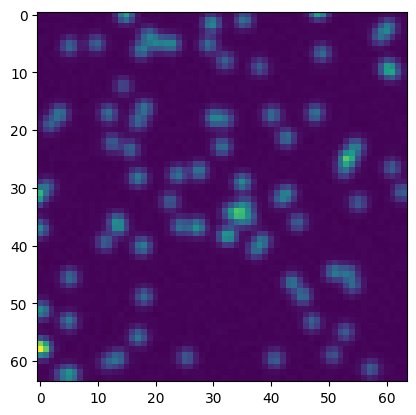

In [3]:
for i in range(1):
    print(f"image {i+1}",
          "\ncount\n", true_counts[i].round().item(),
          "\ntotal flux\n", true_fluxes[i].sum().item(),
          "\nloc\n", true_locs[i].cpu().numpy(), "\n\n")
    fig, img = plt.subplots(1,1)
    _ = img.imshow(images[i].cpu())

### Perform inference with SMC

We set the side length of the tiles on which we will run the sampler, and we specify a prior and image model at the tile level. We also specify a mutation kernel to be used within the SMC sampler.

In [4]:
tile_dim = 8

TilePrior = StarPrior(max_objects = 3,
                      image_dim = tile_dim,
                      min_flux = 10000,
                      pad = 4)

TileImageModel = ImageModel(image_dim = tile_dim,
                            psf_stdev = 1,
                            background = 20000)

MHKernel = MetropolisHastings(num_iters = 100,
                              locs_stdev = 0.25,
                              features_stdev = 1250)

Now we initialize an `SMCsampler` object and run it on the tiles.

In [5]:
smc = SMCsampler(image = images[0],
                 tile_dim = tile_dim,
                 Prior = TilePrior,
                 ImageModel = TileImageModel,
                 MutationKernel = MHKernel,
                 num_catalogs_per_count = 500,
                 max_smc_iters = 500)

print(f"True count: {true_counts[0]}")
print(f"True total flux: {true_fluxes[0].sum()}\n")

smc.run(print_progress = True)
smc.summarize()

True count: 87
True total flux: 8818305.0

Starting the tile samplers...
iteration 5, temperature = 0.0002875602513086051
iteration 10, temperature = 0.0012004765449091792
iteration 15, temperature = 0.004263522103428841
iteration 20, temperature = 0.015185526572167873
iteration 25, temperature = 0.050658389925956726
iteration 30, temperature = 0.08719681203365326
iteration 35, temperature = 0.25618886947631836
iteration 40, temperature = 0.6805338263511658
Done!

summary
number of SMC iterations: 42
